In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import root_scalar
from sklearn.linear_model import (LinearRegression, HuberRegressor,
                                  RANSACRegressor, TheilSenRegressor)

In [2]:
from bokeh.layouts import layout
from bokeh.models import Slider, CustomJS
from bokeh.plotting import figure, show, ColumnDataSource, output_file, save
from bokeh.io import output_notebook

In [3]:
from matplotlib.pyplot import step

output_notebook()
p0 = figure(height=400, width=800)
p1 = figure(height=300, width=400)
p2 = figure(height=300, width=400)
p3 = figure(height=220, width=800)
p4 = figure(height=300, width=400)
p5 = figure(height=300, width=400)
p6 = figure(height=300, width=800)
p7 = figure(height=220, width=800)


Loading BokehJS ...

In [4]:
k = 1.8243677006201693

In [5]:
def find_fiber(edges, **args):
    # global p1
    y, x = edges.shape
    num = np.tile(np.linspace(0, 1, y), (x, 1)).T
    if args.get('plot') == True:
        p1.image(image=[edges], x=0, y=0, dw=1, dh=1, palette="Spectral11")
    edges = edges > 0
    s = np.sum(edges, axis=0)
    m = np.sum(edges * num, axis=0) / s
    st = np.std(edges * num, axis=0)
    std = np.median(st)
    # if args.get('plot') == True:
    #     plt.plot(st, 'o')
    #     plt.plot([0, x - 1], [std, std])
    #     plt.show()
    X = np.linspace(0, 1, x)
    bad = np.argwhere(np.isnan(m))
    X = np.delete(X, bad)
    m = np.delete(m, bad)
    ransac = RANSACRegressor(random_state=42).fit(X.reshape([-1, 1]), m)
    if args.get('plot') == True:
        pred = ransac.predict(X[[0, -1]].reshape([-1, 1]))
        p2.circle(X, m, size=5)
        p2.line([0, 1], pred, line_color='red')
    return float(ransac.estimator_.coef_), float(ransac.predict([[0]])), std


def turn_crop(im, alf, b, std, **args):
    w = args.get('width', 4)
    up = max(b, b + alf)
    down = min(b, b + alf)
    y, x = im.shape
    up = int(np.clip(up + w * std, 0, 1) * y)
    down = int(np.clip(down - w * std, 0, 1) * y)
    cr_im = im[down:up, :]
    y_new = cr_im.shape[0]
    M = cv2.getRotationMatrix2D([x / 2, y_new / 2],
                                np.arctan(alf * y / x) * 180 / np.pi, 1)
    rotated = cv2.warpAffine(cr_im,
                             M, [cr_im.shape[1], cr_im.shape[0]],
                             borderMode=cv2.BORDER_REPLICATE)
    y_min = int(y_new / 2 - w * std * y)
    y_max = int(y_new / 2 + w * std * y)
    rotated = rotated[y_min:y_max]
    if args.get('plot') == True:
        p3.image(image=[rotated],
                 x=0,
                 y=0,
                 dw=1,
                 dh=rotated.shape[0]/y,
                 palette="Spectral11")
        # plt.imshow(rotated)
        # plt.show()
    return rotated


def cuts(m, n):
    y, x = m.shape
    step = x / n
    b = np.ceil(np.arange(step, x, step)).astype(int)
    lis = np.split(m, b, axis=1)
    means = []
    for l in lis:
        means.append(l.mean(axis=1))
    return np.stack(means)


def fit(m, x):
    ransac = RANSACRegressor(random_state=42).fit(x.reshape([-1, 1]), m)
    pred = ransac.predict(x.reshape([-1, 1]))
    std = np.mean((pred - m)**2)
    return std, {'x': x[[0, -1]], 'y': pred[[0, -1]]}


class window_fit():
    def __init__(self, mas, w):
        self.mas = mas
        self.w = w
        self.x, self.y = mas.shape
        self.v = np.ones_like(mas) * float('-inf')
        self.Y = np.arange(self.y)
        self.boards = np.zeros([self.x, 2])

    def get(self, x, y):
        y -= self.w / 2
        x0 = math.floor(x)
        x1 = math.ceil(x)
        y0 = math.floor(y)
        y1 = math.ceil(y)
        s0 = self.calc(x0, y0)
        s1 = self.calc(x1, y1)
        s = s1 * (y - y0) + s0 * (1 - (y - y0))
        return s

    def calc(self, x, y):
        if self.v[x, y] == float('-inf'):
            s, p = fit(self.mas[x, y:y + self.w], self.Y[y:y + self.w])
            self.v[x, y] = math.log(s)
            return math.log(s)
        else:
            return self.v[x, y]

    def get_betwin(self, y0, y1):
        y0, y1 = min(y0, y1), max(y0, y1)
        y0 = max(0, math.ceil(y0))
        y1 = min(self.y - 1, math.floor(y1))
        return np.arange(y0, y1 + 1)

    def get_mas(self, x):
        X = np.argwhere(self.v[x] != float('-inf'))
        Y = self.v[x, X]
        X = X + self.w / 2
        return X.flatten(), Y.flatten()

    def calc_gerd(self, n):
        Y = np.ceil(np.linspace(0, self.y - self.w - 1, n)).astype(int)
        for x in range(self.x):
            for y in Y:
                self.calc(x, y)

    def find_borders(self, kof):
        for x in range(self.x):
            p, val = self.get_mas(x)
            # plt.plot(p,val)
            # plt.show()
            ma = val.max()
            mi = val.min()
            tr = mi * kof + ma * (1 - kof)
            ind = np.argwhere(val > tr).flatten()
            b = [ind.min() - 1, ind.min()]
            # print(x,b)
            # print(x,p[b])
            y0 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            b = [ind.max(), ind.max() + 1]
            y1 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            self.boards[x, :] = [y0 + self.w / 2 - 0.5, y1 - self.w / 2 - 0.5]

In [6]:
# im = cv2.imread('testPic/im1.0.jpg', cv2.IMREAD_GRAYSCALE)
im = cv2.imread('testPic/im0.5.jpg', cv2.IMREAD_GRAYSCALE)
p0.image(image=[im], x=0, y=0, dw=1, dh=1, palette="Spectral11")
y, x = im.shape
kof = 20
tr = 100
im4 = cv2.resize(im, dsize=(x // kof, y // kof))
edges = cv2.Canny(im4, tr, tr, L2gradient=True)
alf, b, std = find_fiber(edges, plot=True)
rotated = turn_crop(im, alf, b, std, width=1, plot=True)
mas = cuts(rotated, 30)
# p4.line(np.linspace(0,1,mas.shape[1]),mas[0])
wf = window_fit(mas, 40)
wf.calc_gerd(10)
wf.find_borders(0.5)

C:\Users\ariva\AppData\Local\Temp\ipykernel_1068\3309256138.py:9: RuntimeWarning: invalid value encountered in divide
  m = np.sum(edges * num, axis=0) / s


In [7]:
p4 = figure(height=300, width=400)
p5 = figure(height=300, width=400)
p6 = figure(height=300, width=800)
p7 = figure(height=220, width=800)
x = 20
y0 = wf.boards[x, 0]
y1 = wf.boards[x, 1]
ins = wf.mas[x, wf.get_betwin(y0, y1)]
ma = ins.max()
mi = ins.min()
vals = [mi, ma, ma, mi, mi]
points = [y0, y0, y1, y1, y0]
p4.line(points, vals, line_color='red')
p4.circle(wf.Y, wf.mas[x], size=5)

X, Y = wf.get_mas(x)
vals = [wf.get(x, y0 - wf.w / 2 + 0.5), wf.get(x, y1 + wf.w / 2 + 0.5)]
points = [y0 - wf.w / 2 + 0.5, y1 + wf.w / 2 + 0.5]
vals = [wf.get(x, points[0]), wf.get(x, points[1])]
p5.line(X, Y)
p5.circle(X, Y)
p5.line(points, vals, line_color='red')

X = np.linspace(0,1,wf.boards.shape[0])
p6.line(X, wf.boards[:, 0] * k)
p6.line(X, wf.boards[:, 1] * k)
p7.line(X, (wf.boards[:, 1] - wf.boards[:, 0]) * k)

GlyphRenderer(id='1469', ...)

In [8]:
p = layout([[p0], [p1, p2], [p3], [p4, p5],[p6],[p7]])
show(p)

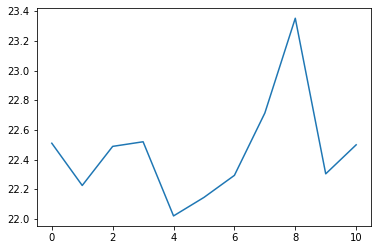

In [10]:
plt.plot((wf.boards[:, 1] - wf.boards[:, 0])[19:])

In [26]:
k = 125 / (wf.boards[:, 1] - wf.boards[:, 0])[20:].mean()

In [27]:
k

1.8243677006201693

In [29]:
(wf.boards[:, 1] - wf.boards[:, 0])[20:].std() / (wf.boards[:, 1] - wf.boards[:, 0])[20:].mean() * k

0.01660753618045307

In [12]:
output_file("linea.html")
save(p)

'C:\\Users\\ariva\\projects\\table_control\\jupiter\\linea.html'